In [1]:
from pathlib import Path


data_path = Path("ParlaMint")
if not data_path.exists():
    raise FileNotFoundError("Please run ./download_data.sh to download the data.")

exploration_language = 'TR'
exploration_path = data_path / "Samples" / f"ParlaMint-{exploration_language}"

# Load XML files from ALL countries
xml_en_files = []
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        country_code = country_dir.name.replace("ParlaMint-", "")
        xml_en_files.extend(list(country_dir.rglob("*-en_*.ana.xml")))

print(f"Found {len(xml_en_files)} XML files from all countries.")

Found 87 XML files from all countries.


In [2]:
from lxml import etree
import pandas as pd

NS = {"tei": "http://www.tei-c.org/ns/1.0"}

def parse_parlamint_xml(xml_path):
    tree = etree.parse(str(xml_path))
    root = tree.getroot()

    date_node = root.xpath("//tei:date/@when", namespaces=NS) 
    file_date = date_node[0] if date_node else "Unknown"

    data = []
    utterances = root.xpath(".//tei:u", namespaces=NS)
    
    for u in utterances:
        u_id = u.get("{http://www.w3.org/XML/1998/namespace}id")
        speaker = u.get("who")
        ana = u.get("ana", "")
        topics = [a.replace("topic:", "") for a in ana.split() if "topic:" in a]

        sentences = u.xpath(".//tei:s", namespaces=NS)
        for s in sentences:
            s_id = s.get("{http://www.w3.org/XML/1998/namespace}id")
            
            sentiment_node = s.xpath(".//tei:measure[@type='sentiment']", namespaces=NS)
            sentiment_score = float(sentiment_node[0].get("quantity")) if sentiment_node else None
            
            named_entities = s.xpath(".//tei:name/@type", namespaces=NS)
            
            tokens = []
            reconstructed_text = ""
            
            token_elements = s.xpath(".//tei:w | .//tei:pc", namespaces=NS)
            
            for i, token_el in enumerate(token_elements):
                token_text = token_el.text or ""
                
                token_data = {
                    "text": token_text,
                    "type": "word" if token_el.tag.endswith("w") else "punct",
                    "lemma": token_el.get("lemma"),
                    "pos": token_el.get("pos"),
                    "msd": token_el.get("msd"),
                    "sem": token_el.get("function")
                }
                tokens.append(token_data)
                
                reconstructed_text += token_text
                if token_el.get("join") != "right" and i < len(token_elements) - 1:
                    reconstructed_text += " "

            data.append({
                "u_id": u_id,
                "s_id": s_id,
                "speaker": speaker,
                "topics": topics,
                "sentiment": sentiment_score,
                "entities": list(set(named_entities)),
                "text": reconstructed_text,
                "tokens": tokens, 
                "date": file_date,
            })
            
    return data

all_data = []
for xml_file in xml_en_files:
    all_data.extend(parse_parlamint_xml(xml_file))

xml_df = pd.DataFrame(all_data)
print(f"Extracted {len(xml_df)} sentences from {len(xml_en_files)} XML files.")

if not xml_df.empty:
    print("\nClean Text for first sentence:")
    print(xml_df.iloc[0]['text'])
    print("\nToken metadata for first 3 tokens of first sentence:")
    print(pd.DataFrame(xml_df.iloc[0]['tokens']).head(3))


Extracted 5432 sentences from 87 XML files.

Clean Text for first sentence:
Madam President, I would like

Token metadata for first 3 tokens of first sentence:
        text   type      lemma  pos                        msd  sem
0      Madam   word      madam  NNP  UPosTag=PROPN|Number=Sing  Z1f
1  President   word  President  NNP  UPosTag=PROPN|Number=Sing  Z1f
2          ,  punct       None    Z              UPosTag=PUNCT   Z9


In [3]:
def load_taxonomy(taxonomy_path):
    tree = etree.parse(str(taxonomy_path))
    categories = tree.xpath("//tei:category", namespaces=NS)
    mapping = {}
    for cat in categories:
        cat_id = cat.get("{http://www.w3.org/XML/1998/namespace}id")
        full_desc = cat.xpath("string(./tei:catDesc)", namespaces=NS)
        if cat_id and full_desc:
            if ":" in full_desc:
                mapping[cat_id] = full_desc.split(":", 1)[-1].strip()
            else:
                mapping[cat_id] = full_desc.strip()
    return mapping

usas_tax_path = exploration_path / "ParlaMint-taxonomy-USAS.ana.xml"
usas_map = load_taxonomy(usas_tax_path)

print(f"Z5 means: {usas_map.get('Z5')}")
print(f"A1.1.1 means: {usas_map.get('A1.1.1')}")

Z5 means: Grammatical bin
A1.1.1 means: General actions / making


In [4]:
topic_tax_path = exploration_path / "ParlaMint-taxonomy-topic.xml"
topic_map = load_taxonomy(topic_tax_path)

print(f"Topic 'educa' means: {topic_map.get('educa')}")
print(f"Topic 'healt' means: {topic_map.get('healt')}")

Topic 'educa' means: Education
Topic 'healt' means: Health


In [5]:
speaker_tax_path = exploration_path / "ParlaMint-taxonomy-politicalOrientation.xml"
speaker_map = load_taxonomy(speaker_tax_path)

print(f"Speaker orientation 'orientation.C' means: {speaker_map.get('orientation.C')}")

Speaker orientation 'orientation.C' means: Centre


In [6]:
ches_tax_path = exploration_path / "ParlaMint-taxonomy-CHES.xml"
ches_map = load_taxonomy(ches_tax_path)

print(f"CHES 'ches.general' means: {ches_map.get('ches.general')}")

CHES 'ches.general' means: General indicators used to identify basic characteristics of a political party, such as country of origin, number of experts evaluating a party, membership in the EU, etc.


In [7]:
named_entity_tax_path = exploration_path / "ParlaMint-taxonomy-NER.ana.xml"
named_entity_map = load_taxonomy(named_entity_tax_path) 

print(f"Named entity 'PER' means: {named_entity_map.get('PER')}")

Named entity 'PER' means: person


In [8]:
legislature_tax_path = exploration_path / "ParlaMint-taxonomy-parla.legislature.xml"
legislature_map = load_taxonomy(legislature_tax_path)

print(f"Legislature type 'parla.organization' means: {legislature_map.get('parla.organization')}")
print(f"Legislature type 'parla.uni' means: {legislature_map.get('parla.uni')}")

Legislature type 'parla.organization' means: Organization
Legislature type 'parla.uni' means: Unicameralism


In [9]:
sentiment_tax_path = exploration_path / "ParlaMint-taxonomy-sentiment.ana.xml"
sentiment_map = load_taxonomy(sentiment_tax_path)

print(f"Sentiment 'neuneg' means: {sentiment_map.get('neuneg')}")

Sentiment 'neuneg' means: interval [1.5, 2.5)


In [10]:
speaker_type_tax_path = exploration_path / "ParlaMint-taxonomy-speaker_types.xml"
speaker_type_map = load_taxonomy(speaker_type_tax_path)

print(f"Speaker type 'chair' means: {speaker_type_map.get('chair')}")

Speaker type 'chair' means: chairman of a sitting


In [11]:
def load_person_list(person_path):
    tree = etree.parse(str(person_path))
    root = tree.getroot()
    
    persons = root.xpath("//tei:person", namespaces=NS)
    person_mapping = {}
    
    for p in persons:
        p_id = p.get("{http://www.w3.org/XML/1998/namespace}id")
        
        # Get full name
        forenames = p.xpath(".//tei:persName/tei:forename/text()", namespaces=NS)
        surname = p.xpath(".//tei:persName/tei:surname/text()", namespaces=NS)
        full_name = f"{' '.join(forenames)} {''.join(surname)}".strip()
        
        # Get sex
        sex = p.xpath("./tei:sex/@value", namespaces=NS)
        sex = sex[0] if sex else None
        
        # Get current/last party affiliation
        affiliations = p.xpath(".//tei:affiliation[contains(@ref, '#')]", namespaces=NS)
        party_ref = affiliations[-1].get("ref").replace("#", "") if affiliations else None

        # Create a list of (party_ref, start_date, end_date) tuples
        party_info = []
        for aff in affiliations:
            party_ref = aff.get("ref").replace("#", "")
            start_date = aff.get("from")
            end_date = aff.get("to")
            party_info.append((party_ref, start_date, end_date))

        person_mapping[f"#{p_id}"] = {
            "name": full_name,
            "sex": sex,
            "party": party_ref,
            "party_info": party_info
        }
        
    return person_mapping

person_path = exploration_path / "ParlaMint-TR-listPerson.xml"
speaker_info = load_person_list(person_path)

example_id = "#Abdulkadir.Akgül"
print(f"Info for {example_id}: {speaker_info.get(example_id)}")

Info for #Abdulkadir.Akgül: {'name': 'Abdulkadir Akgül', 'sex': 'M', 'party': 'party.AKP', 'party_info': [('TBMM', '2007-07-23', '2011-04-23'), ('TBMM', '2015-06-23', '2015-10-01'), ('parliamentaryGroup.AKP', '2015-06-23', '2015-10-01'), ('TBMM', '2015-11-17', '2018-05-16'), ('parliamentaryGroup.AKP', '2015-11-17', '2018-05-16'), ('party.AKP', None, None)]}


In [12]:
def load_org_list(org_path):
    tree = etree.parse(str(org_path))
    root = tree.getroot()
    
    orgs = root.xpath("//tei:org", namespaces=NS)
    org_mapping = {}
    
    for org in orgs:
        org_id = org.get("{http://www.w3.org/XML/1998/namespace}id")
        role = org.get("role")
        
        full_name = org.xpath("./tei:orgName[@full='yes']/text()", namespaces=NS)
        full_name = full_name[0] if full_name else None
        
        if not full_name:
            any_name = org.xpath("./tei:orgName/text()", namespaces=NS)
            full_name = any_name[0] if any_name else None
            
        org_mapping[org_id] = {
            "name": full_name.strip() if full_name else None,
            "role": role
        }
        
    return org_mapping

org_path = exploration_path / "ParlaMint-TR-listOrg.xml"
org_info = load_org_list(org_path)

print(f"Info for 'TBMM': {org_info.get('TBMM')}")
print(f"Info for 'party.AKP': {org_info.get('party.AKP')}")


Info for 'TBMM': {'name': 'National Assembly of the Republic of Turkey', 'role': 'parliament'}
Info for 'party.AKP': {'name': 'Adalet ve Kalkınma Partisi', 'role': 'politicalParty'}


In [ ]:
def get_party_at_time(row, speaker_info):
    speaker = row['speaker'] # or 'speaker' depending on your col name
    speech_date = row['date']
    
    # Get the list of tuples for this speaker
    # party_info = [(name, from, to), (name, from, to), ...]
    speaker_data = speaker_info.get(speaker, {})
    affiliations = speaker_data.get('party_info', [])
    
    if not affiliations or affiliations == 'Unknown':
        return 'Unknown'
    
    # Iterate through affiliations to find the matching date range
    for party_name, date_from, date_to in affiliations:
        # Standardize dates for comparison (if they aren't already)
        # ParlaMint dates are usually 'YYYY-MM-DD'
        # Handle cases where date_to might be empty (still in party)
        start = date_from if date_from else '0001-01-01'
        end = date_to if date_to else '9999-12-31'
        
        if start <= speech_date <= end:
            return party_name
            
    return speaker_data.get('party', 'Unknown')

final_df = xml_df.copy()

# Initialize columns with default values
final_df['speaker_name'] = 'Unknown'
final_df['speaker_sex'] = 'Unknown'
final_df['party_id'] = 'Unknown'
final_df['party_name'] = 'Unknown'
final_df['topic_labels'] = final_df['topics'].map(lambda t_list: [topic_map.get(t, t) for t in t_list] if t_list else [])
final_df['country_code'] = 'Unknown'
final_df['source_file'] = 'Unknown'

# Map each row to its source XML file to extract country code
print("Mapping rows to source files and extracting country codes...")
xml_file_to_country = {}
for xml_file in xml_en_files:
    # Parse the XML file to get utterance IDs
    tree = etree.parse(str(xml_file))
    root = tree.getroot()
    utterances = root.xpath(".//tei:u", namespaces=NS)
    
    # Extract country code from file path
    country_code = None
    for part in str(xml_file).split('/'):
        if part.startswith('ParlaMint-'):
            country_code = part.replace('ParlaMint-', '')
            break
    
    if country_code:
        for u in utterances:
            u_id = u.get("{http://www.w3.org/XML/1998/namespace}id")
            if u_id:
                xml_file_to_country[u_id] = country_code

# Map u_id to country_code
final_df['country_code'] = final_df['u_id'].map(lambda x: xml_file_to_country.get(x, 'Unknown'))

# Enrich with country-specific speaker and organization data
print("Enriching final_df with country-specific speaker and party information...")
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        country_code = country_dir.name.replace("ParlaMint-", "")
        
        person_path = country_dir / f"ParlaMint-{country_code}-listPerson.xml"
        org_path = country_dir / f"ParlaMint-{country_code}-listOrg.xml"
        
        if not person_path.exists() or not org_path.exists():
            continue
        
        # Load country-specific data
        country_speaker_info = load_person_list(person_path)
        country_org_info = load_org_list(org_path)
        
        # Get mask for this country's rows
        country_mask = final_df['country_code'] == country_code
        
        if country_mask.sum() == 0:
            continue

        # Enrich speaker info for this country
        final_df.loc[country_mask, 'speaker_name'] = final_df.loc[country_mask, 'speaker'].map(
            lambda x: country_speaker_info.get(x, {}).get('name', 'Unknown')
        )
        final_df.loc[country_mask, 'speaker_sex'] = final_df.loc[country_mask, 'speaker'].map(
            lambda x: country_speaker_info.get(x, {}).get('sex', 'Unknown')
        )
        final_df.loc[country_mask, 'party_id'] = final_df[country_mask].apply(
            lambda row: get_party_at_time(row, country_speaker_info), axis=1
        )
        final_df.loc[country_mask, 'party_name'] = final_df.loc[country_mask, 'party_id'].map(
            lambda x: country_org_info.get(x, {}).get('name', 'Unknown')
        )



# Display results, include also speech date
columns_to_show = [
    's_id', 'country_code', 'speaker_name', 'speaker_sex', 'party_id', 'party_name',
    'sentiment', 'topic_labels', 'text', 'date'
]

print(f"Final dataset built with {len(final_df)} rows and {len(final_df.columns)} columns.")
print(f"Countries represented: {final_df['country_code'].unique()}")
print(f"Country distribution:\n{final_df['country_code'].value_counts()}")
final_df[columns_to_show].head(50)

Mapping rows to source files and extracting country codes...
Enriching final_df with country-specific speaker and party information...
Final dataset built with 5432 rows and 16 columns.
Countries represented: ['SE' 'UA' 'PL' 'BE' 'GR' 'NO' 'EE' 'LV' 'CZ' 'IS' 'IT' 'RS' 'SI' 'PT'
 'ES-GA' 'GB' 'BA' 'ES-PV' 'AT' 'DK' 'BG' 'HU' 'NL' 'HR' 'FR' 'ES' 'FI'
 'ES-CT' 'TR']
Country distribution:
country_code
CZ       644
SE       602
TR       433
UA       365
RS       289
HU       274
IS       266
ES-CT    256
GB       198
BG       192
PL       177
BA       154
ES-PV    138
SI       137
GR       127
EE       115
FR       113
LV       110
BE       100
DK        99
HR        97
NL        94
ES-GA     75
PT        71
IT        69
FI        67
AT        65
NO        57
ES        48
Name: count, dtype: int64


,s_id,country_code,speaker_name,speaker_sex,party_id,party_name,sentiment,topic_labels,text,date
0,i-7Gocwwgm1SAsUELPMWzXuE,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,4.017,[Mix],"Madam President, I would like",2025-06-23
1,i-7GodASKwaGTGUA8Kq8nQCL,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,2.313,[Mix],Anders Åkesson has asked me when and in what w...,2025-06-23
2,i-7GodHw7T7ZphsKCgv74KaC,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,2.331,[Mix],The County Administrative Board of Kalmar Coun...,2025-06-23
3,i-7GodPmH4ygtVQDNXYCAFye,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,0.572,[Mix],The proposals are aimed at removing the protec...,2025-06-23
4,i-7GodVbSgqoxGw7YNAHGCP6,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,1.452,[Mix],As the matter is still being prepared in the G...,2025-06-23
5,i-7GodbRcJhw24U1iCnNN8nY,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,2.786,[Mix],Anders Åkesson also addresses the emerging sit...,2025-06-23
6,i-7Godi65sQeEfw3LJdu44gC,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,0.626,[Mix],I share Anders Åkesson's concern about the sit...,2025-06-23
7,i-7GodovFVGmJTTwW9FzA15e,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,0.981,[Mix],The Government is therefore now proposing a cr...,2025-06-23
8,i-7GodukR78tNEzqfyt5FwV6,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,3.137,[Mix],The package is based on an agreement between t...,2025-06-23
9,i-7Goe1aaj11S2XjqpWAMstY,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,3.544,[Mix],With these proposals and the measures previous...,2025-06-23


## Dataset Overview
Basic Statistics

- Number of speeches/documents
- Speech length distribution (word counts)
- Date range coverage
- Number of speakers and organizations

In [21]:
# Number of speeches per country
country_speech_counts = {}
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        country_code = country_dir.name.replace("ParlaMint-", "")
        xml_files = list(country_dir.rglob("*-en_*.ana.xml"))
        total_speeches = 0
        for xml_file in xml_files:
            tree = etree.parse(str(xml_file))
            root = tree.getroot()
            utterances = root.xpath(".//tei:u", namespaces=NS)
            total_speeches += len(utterances)
        country_speech_counts[country_code] = total_speeches

print("Number of speeches per country:")
for country, count in country_speech_counts.items():
    print(f"{country}: {count} speeches")


Number of speeches per country:
SE: 12 speeches
UA: 12 speeches
PL: 12 speeches
BE: 12 speeches
GR: 12 speeches
NO: 12 speeches
EE: 12 speeches
LV: 12 speeches
CZ: 12 speeches
IS: 12 speeches
IT: 12 speeches
RS: 12 speeches
SI: 12 speeches
PT: 12 speeches
ES-GA: 12 speeches
GB: 12 speeches
BA: 12 speeches
ES-PV: 12 speeches
DE: 0 speeches
AT: 8 speeches
DK: 12 speeches
BG: 12 speeches
HU: 12 speeches
NL: 12 speeches
HR: 12 speeches
FR: 12 speeches
ES: 12 speeches
FI: 12 speeches
IL: 0 speeches
ES-CT: 12 speeches
TR: 9 speeches
ES-CN: 0 speeches


As we decided to use only the dataset machine translated to English, we will discard DE, IL, ES-CN and CN.

In [22]:
# Create a list with DE, IL, ES-CN, CN

selected_countries = ['DE', 'IL', 'ES-CN', 'CN']
print(final_df.shape)

# Remove the selected countries from final_df
filtered_df = final_df[~final_df['s_id'].str.contains('|'.join(selected_countries))]
print(filtered_df.shape)

(5432, 16)
(5428, 16)


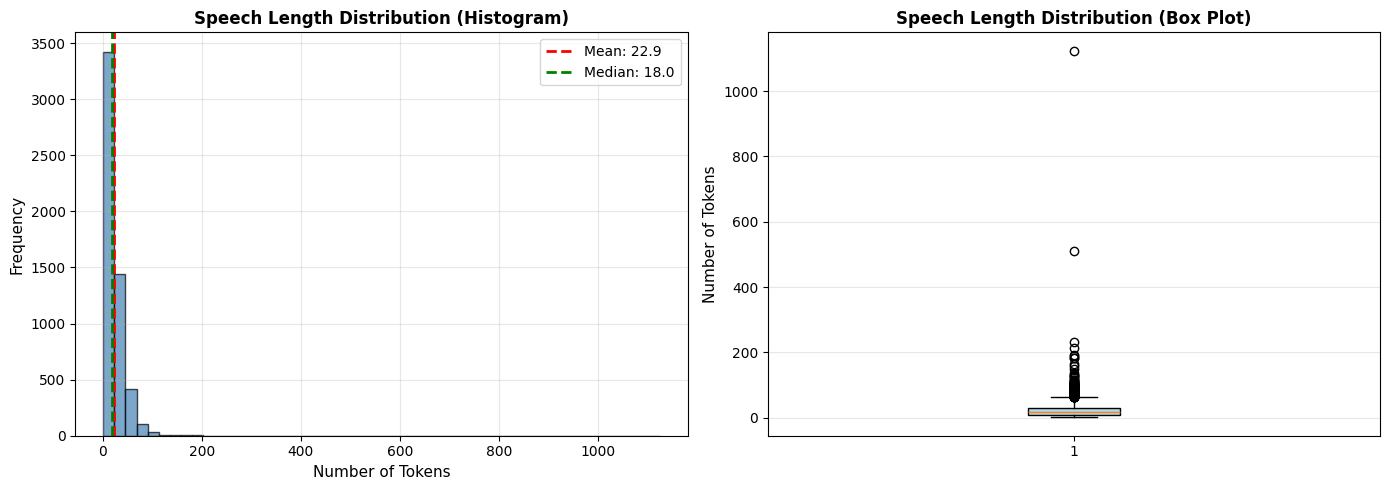

Speech Length Statistics:
  Count:  5432
  Mean:   22.85
  Median: 18.00
  Std:    25.24
  Min:    1
  Max:    1124
  25th percentile: 9
  75th percentile: 30


In [23]:
# Speech length distribution - Enhanced
import matplotlib.pyplot as plt
import numpy as np

final_df['speech_length'] = final_df['tokens'].map(len)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with statistics
ax1 = axes[0]
ax1.hist(final_df['speech_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')

# Add statistical lines
mean_len = final_df['speech_length'].mean()
median_len = final_df['speech_length'].median()
ax1.axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_len:.1f}')
ax1.axvline(median_len, color='green', linestyle='--', linewidth=2, label=f'Median: {median_len:.1f}')

ax1.set_title('Speech Length Distribution (Histogram)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Tokens', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(final_df['speech_length'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax2.set_title('Speech Length Distribution (Box Plot)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Tokens', fontsize=11)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Speech Length Statistics:")
print(f"  Count:  {len(final_df)}")
print(f"  Mean:   {mean_len:.2f}")
print(f"  Median: {median_len:.2f}")
print(f"  Std:    {final_df['speech_length'].std():.2f}")
print(f"  Min:    {final_df['speech_length'].min()}")
print(f"  Max:    {final_df['speech_length'].max()}")
print(f"  25th percentile: {final_df['speech_length'].quantile(0.25):.0f}")
print(f"  75th percentile: {final_df['speech_length'].quantile(0.75):.0f}")

In [24]:
# Data range coverage
date_ranges = {}
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        # If the country is in selected_countries, skip it
        if country_dir.name.replace("ParlaMint-", "") in selected_countries:
            continue
        country_code = country_dir.name.replace("ParlaMint-", "")
        xml_files = list(country_dir.rglob("*-en_*.ana.xml"))
        min_date, max_date = None, None
        for xml_file in xml_files:
            tree = etree.parse(str(xml_file))
            root = tree.getroot()
            dates = root.xpath("//tei:date/@when", namespaces=NS)
            for date_str in dates:
                if min_date is None or date_str < min_date:
                    min_date = date_str
                if max_date is None or date_str > max_date:
                    max_date = date_str
        date_ranges[country_code] = (min_date, max_date)

print("Data range coverage per country:")
for country, (start_date, end_date) in date_ranges.items():
    print(f"{country}: from {start_date} to {end_date}")

Data range coverage per country:
SE: from 2017-12-12 to 2025-06-23
UA: from 2008-09-30 to 2025-06-23
PL: from 2017-07-20 to 2025-06-23
BE: from 2017-04-27 to 2025-06-23
GR: from 2017-06-09 to 2025-06-23
NO: from 2004-06-08 to 2025-06-23
EE: from 2014-12-02 to 2025-06-23
LV: from 2019-01-31 to 2025-06-23
CZ: from 2016-10-27 to 2025-06-23
IS: from 2017-03-20 to 2025-06-30
IT: from 2015-06-10 to 2025-06-23
RS: from 2008-07-18 to 2025-06-25
SI: from 2007-11-28 to 2025-06-23
PT: from 2017-11-29 to 2025-06-23
ES-GA: from 2017-05-24 to 2025-06-23
GB: from 2017-09-07 to 2025-06-23
BA: from 2006-07-07 to 2025-06-24
ES-PV: from 2017-10-05 to 2025-06-23
AT: from 2005-04-27 to 2025-06-24
DK: from 2017-05-18 to 2025-06-23
BG: from 2017-05-11 to 2025-06-23
HU: from 2016-12-07 to 2025-06-23
NL: from 2017-01-26 to 2025-06-23
HR: from 2011-05-05 to 2025-06-25
FR: from 2019-01-16 to 2025-06-23
ES: from 2017-11-28 to 2025-06-23
FI: from 2017-10-04 to 2025-06-23
ES-CT: from 2018-05-04 to 2025-06-23
TR: fr

In [25]:
# Number of speakers and organizations per country
country_speaker_org_counts = {}
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        # If the country is in selected_countries, skip it
        if country_dir.name.replace("ParlaMint-", "") in selected_countries:
            continue
        country_code = country_dir.name.replace("ParlaMint-", "")
        
        person_path = country_dir / f"ParlaMint-{country_code}-listPerson.xml"
        org_path = country_dir / f"ParlaMint-{country_code}-listOrg.xml"
        
        speaker_info = load_person_list(person_path)
        org_info = load_org_list(org_path)
        
        num_speakers = len(speaker_info)
        num_orgs = len(org_info)
        
        country_speaker_org_counts[country_code] = (num_speakers, num_orgs)

print("Number of speakers and organizations per country:")
for country, (num_speakers, num_orgs) in country_speaker_org_counts.items():
    print(f"{country}: {num_speakers} speakers, {num_orgs} organizations")  

Number of speakers and organizations per country:
SE: 649 speakers, 15 organizations
UA: 2617 speakers, 151 organizations
PL: 1223 speakers, 12 organizations
BE: 786 speakers, 68 organizations
GR: 635 speakers, 16 organizations
NO: 1106 speakers, 17 organizations
EE: 488 speakers, 8 organizations
LV: 234 speakers, 13 organizations
CZ: 597 speakers, 450 organizations
IS: 261 speakers, 12 organizations
IT: 771 speakers, 47 organizations
RS: 1724 speakers, 73 organizations
SI: 973 speakers, 32 organizations
PT: 836 speakers, 25 organizations
ES-GA: 227 speakers, 59 organizations
GB: 1951 speakers, 37 organizations
BA: 603 speakers, 42 organizations
ES-PV: 197 speakers, 11 organizations
AT: 854 speakers, 37 organizations
DK: 383 speakers, 21 organizations
BG: 1032 speakers, 46 organizations
HU: 492 speakers, 94 organizations
NL: 586 speakers, 50 organizations
HR: 1036 speakers, 47 organizations
FR: 908 speakers, 185 organizations
ES: 941 speakers, 52 organizations
FI: 314 speakers, 19 orga

## Gouvernment vs Opposition Anlaysis

- compare speech frequencies, lengths, sentiment between gouvernment and opposition
- identify patterns in who speaks more/longer


COUNTRY: AT

Government coalition parties (ids): ['politicalParty.GRÜNE', 'politicalParty.BZÖ', 'politicalParty.SPÖ', 'politicalParty.ÖVP', 'politicalParty.FPÖ']
Opposition parties (ids): ['politicalParty.GRÜNE', 'politicalParty.LIF', 'politicalParty.STRONACH', 'politicalParty.NEOS', 'politicalParty.ÖVP', 'politicalParty.SPÖ', 'politicalParty.BZÖ', 'politicalParty.JETZT', 'politicalParty.FPÖ']
Not enough classified speeches for AT (found 7), skipping

COUNTRY: BA

Government coalition parties (ids): ['party.K-SNSD', 'party.SDS', 'party.SDP_BIH', 'party.DF', 'party.SLOGA', 'party.PDP-NDP', 'party.NHI-HKDU', 'party.HDZ-HK-HNZ', 'party.KCD_BIH', 'party.KOALICIJA']
Opposition parties (ids): ['party.SD_BIH', 'party.RSRS', 'party.SP', 'party.SDS', 'party.PDA', 'party.HDZ_1990', 'party.SNS', 'party.SRSRS', 'party.DNZ_BIH', 'party.PDP', 'party.HDZ_BIH', 'party.NHI', 'party.SNSD', 'party.NS_RB', 'party.A-SDA', 'party.BOSS', 'party.BPS', 'party.SDUBIH', 'party.DSP_BIH', 'party.SPUBIH', 'party.D

/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])


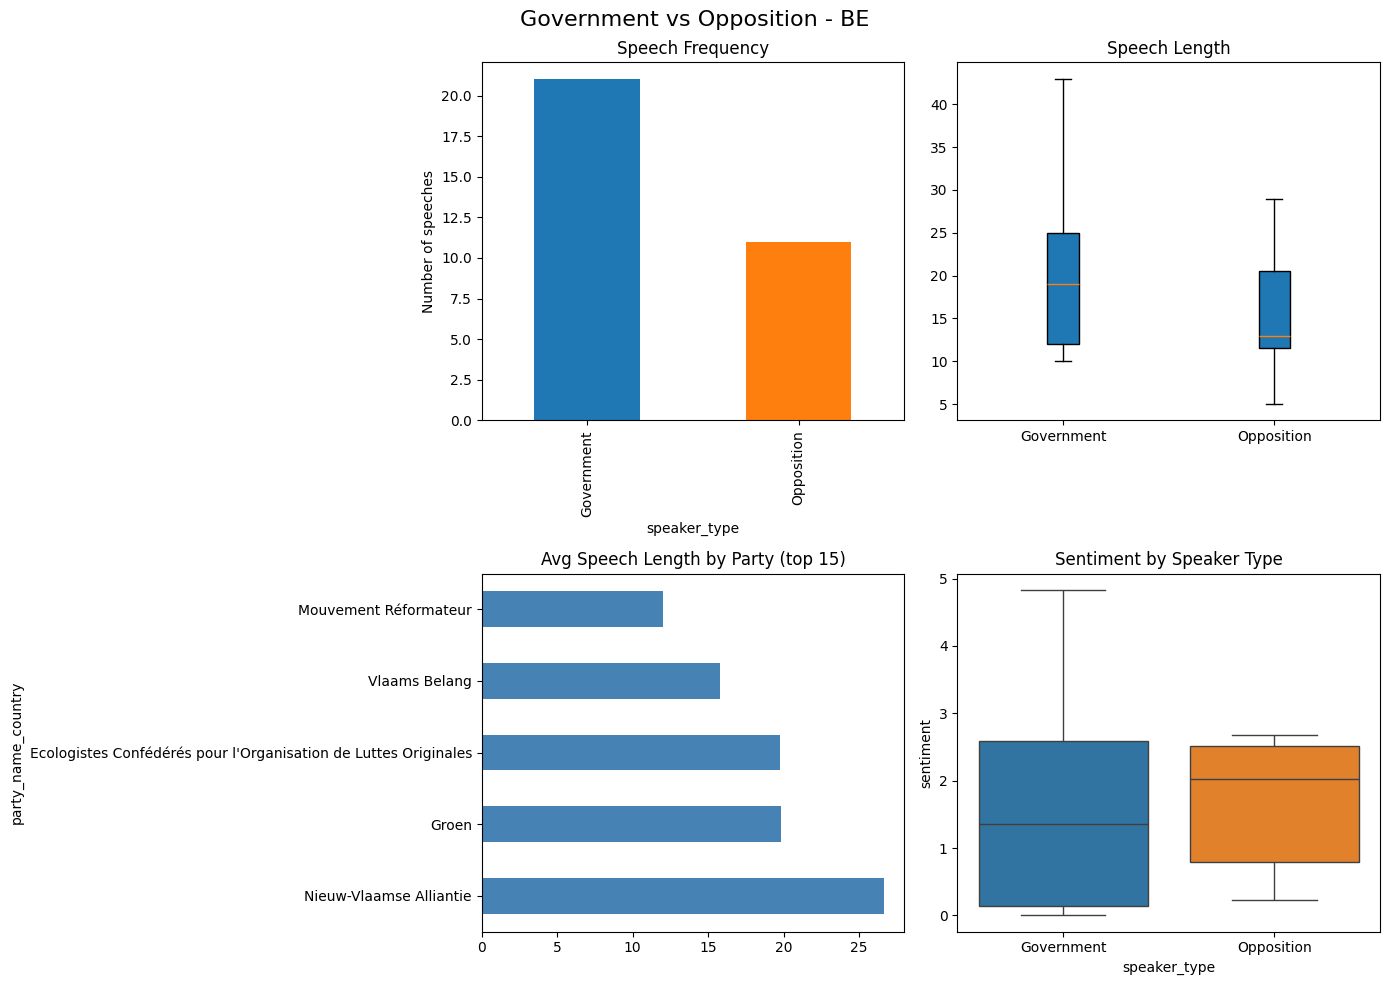


COUNTRY: BG

Government coalition parties (ids): ['parliamentaryGroup.GERB', 'parliamentaryGroup.DB', 'parliamentaryGroup.ABV', 'parliamentaryGroup.TISP', 'parliamentaryGroup.UP', 'parliamentaryGroup.BSPFB', 'parliamentaryGroup.RB', 'parliamentaryGroup.WCC']
Opposition parties (ids): ['parliamentaryGroup.BSPLB', 'parliamentaryGroup.BSPFB', 'parliamentaryGroup.VOLYA', 'parliamentaryGroup.PF', 'parliamentaryGroup.GERB-UDF', 'parliamentaryGroup.MRF', 'parliamentaryGroup.RP']
Not enough classified speeches for BG (found 0), skipping

COUNTRY: CZ

Government coalition parties (ids): ['parliamentaryGroup.ANO', 'parliamentaryGroup.KDU-CSL', 'parliamentaryGroup.Pirati', 'parliamentaryGroup.ODS', 'parliamentaryGroup.TOP09', 'parliamentaryGroup.CSSD', 'parliamentaryGroup.STAN']
Opposition parties (ids): ['parliamentaryGroup.ANO', 'parliamentaryGroup.KDU-CSL', 'parliamentaryGroup.Pirati', 'parliamentaryGroup.ODS', 'parliamentaryGroup.TOP09-S', 'parliamentaryGroup.Usvit.1111', 'parliamentaryGroup

/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])


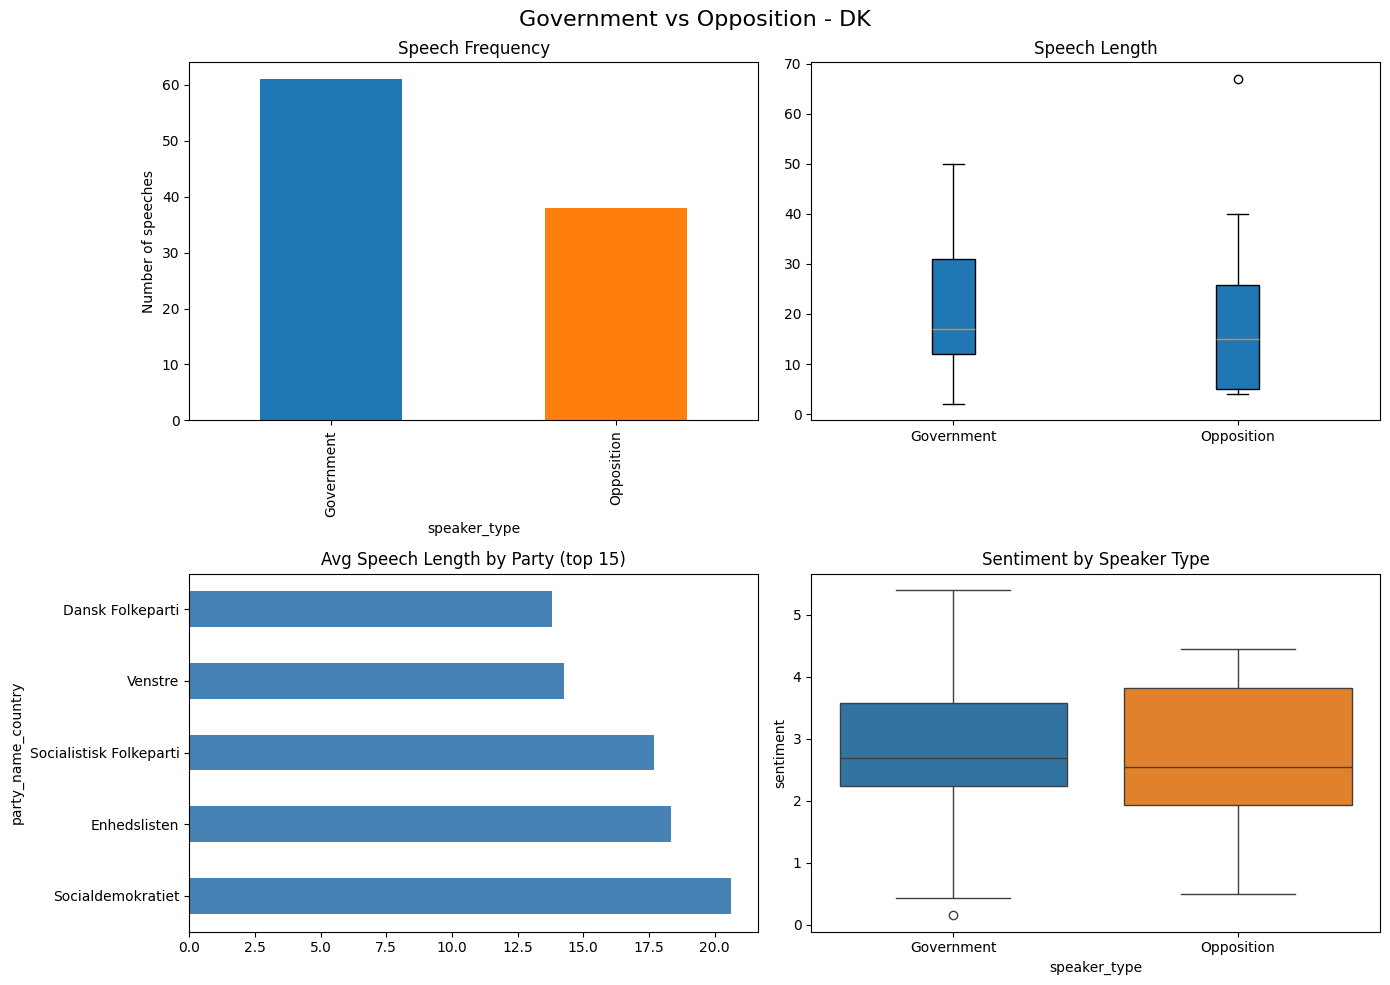

/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])



COUNTRY: EE

Government coalition parties (ids): ['group.KE', 'group.EKRE', 'group.ISA', 'group.SDE', 'group.RE']
Opposition parties (ids): []
Not enough classified speeches for EE (found 0), skipping

COUNTRY: ES

Government coalition parties (ids): ['party.PPFORO', 'party.PSCPSOE', 'party.ECPGUAYEMELCANVI', 'party.PSOE', 'party.ECP', 'party.PSEEEPSOE', 'party.PPEU', 'party.UP', 'party.PP', 'party.UPNPP', 'party.PSdGPSOE', 'party.PPPAR', 'party.ECUP']
Opposition parties (ids): ['party.PSCPSOE', 'party.PSCPSCPSOE', 'party.MÁSPAÍSEQUO', 'party.PSOE', 'party.JxCatJUNTS', 'party.UPyD', 'party.PsdeGPSOE', 'party.PP', 'party.EAJPNV', 'party.ECUP', 'party.IZQPLU', 'party.TeruelExiste', 'party.Cs', 'party.CUPPR', 'party.EHBildu', 'party.PSOEdeAndalucía', 'party.ECPGUAYEMELCANVI', 'party.CCaPNC', 'party.NCCCaPNC', 'party.COMPROMÍSQ', 'party.PSEEEPSOE', 'party.ERCCATSÍ', 'party.UP', 'party.CiU', 'party.ERCS', 'party.DL', 'party.UPM', 'party.Vox', 'party.UPN', 'party.CPEUPV', 'party.PSdGPSOE', 

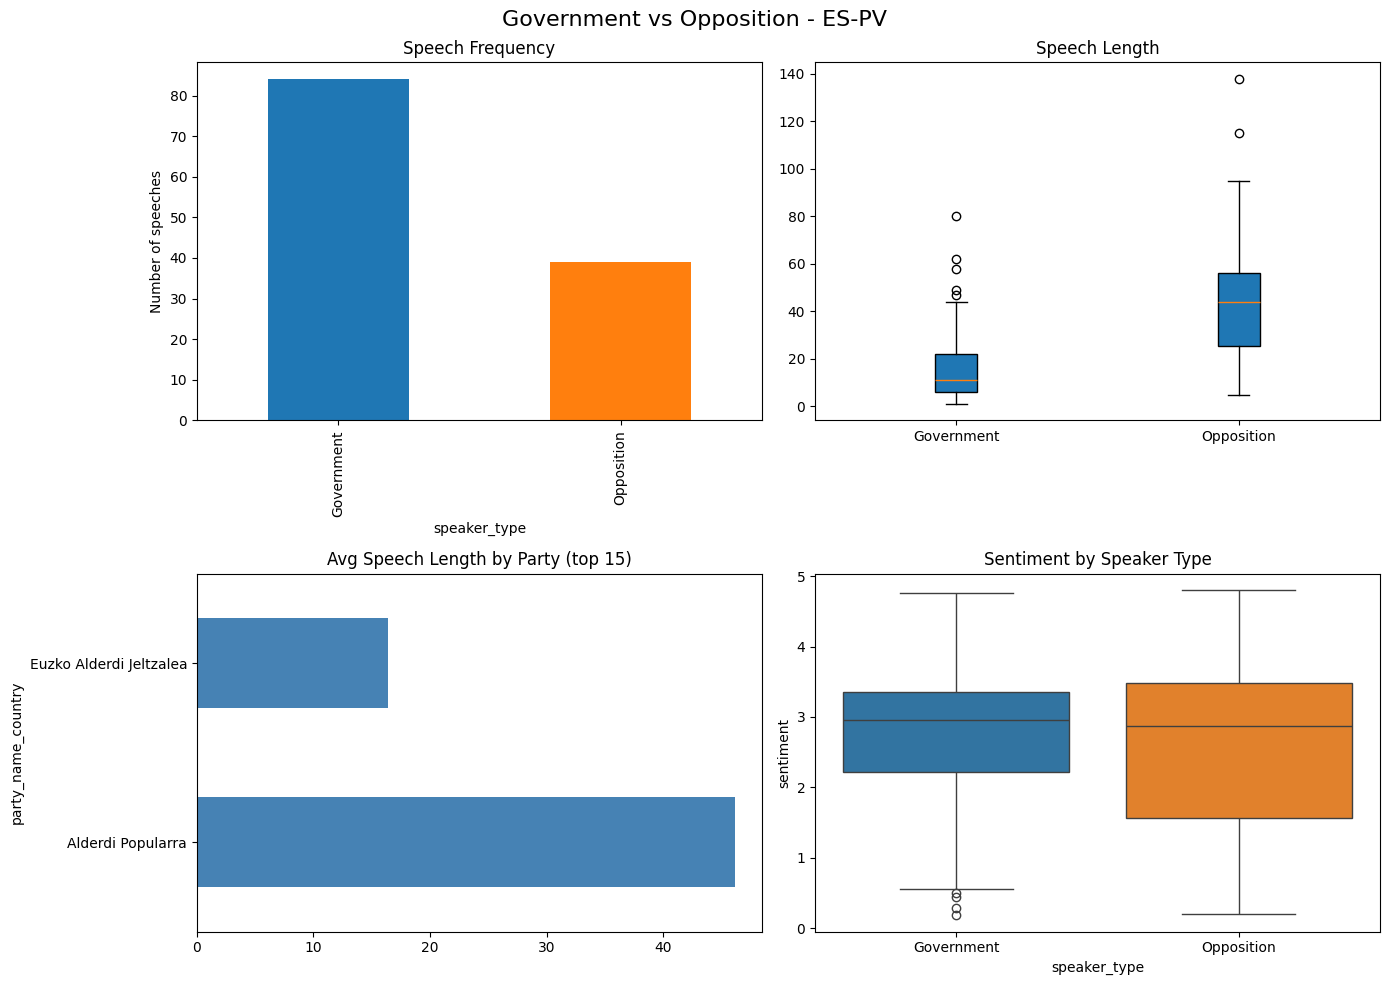


COUNTRY: FI

Government coalition parties (ids): ['party.SIN', 'party.PS', 'party.KD', 'party.VIHR', 'party.VAS', 'party.KESK', 'party.RKP', 'party.KOK', 'party.SDP']
Opposition parties (ids): ['party.KOK', 'party.PS', 'party.TL', 'party.VKK', 'party.KD', 'party.VIHR', 'party.VAS', 'party.LIIK', 'party.RKP', 'party.SDP', 'party.KESK']
Not enough classified speeches for FI (found 0), skipping

COUNTRY: FR

Government coalition parties (ids): ['PO730970', 'PO730964', 'PO771923']
Opposition parties (ids): ['PO765636', 'PO730958', 'PO730946', 'PO730952', 'PO744425', 'PO730940', 'PO771889', 'PO730934']
Not enough classified speeches for FR (found 0), skipping

COUNTRY: GB


/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])



Government coalition parties (ids): ['party.CON', 'party.LD']
Opposition parties (ids): ['party.LAB']

=== SPEECH FREQUENCY ===
speaker_type
Opposition    10
Name: count, dtype: int64

Percentage:
speaker_type
Opposition    100.0
Name: count, dtype: float64

=== SPEECH LENGTH ===

=== SENTIMENT ===
Opposition sentiment mean: 4.136 count: 10


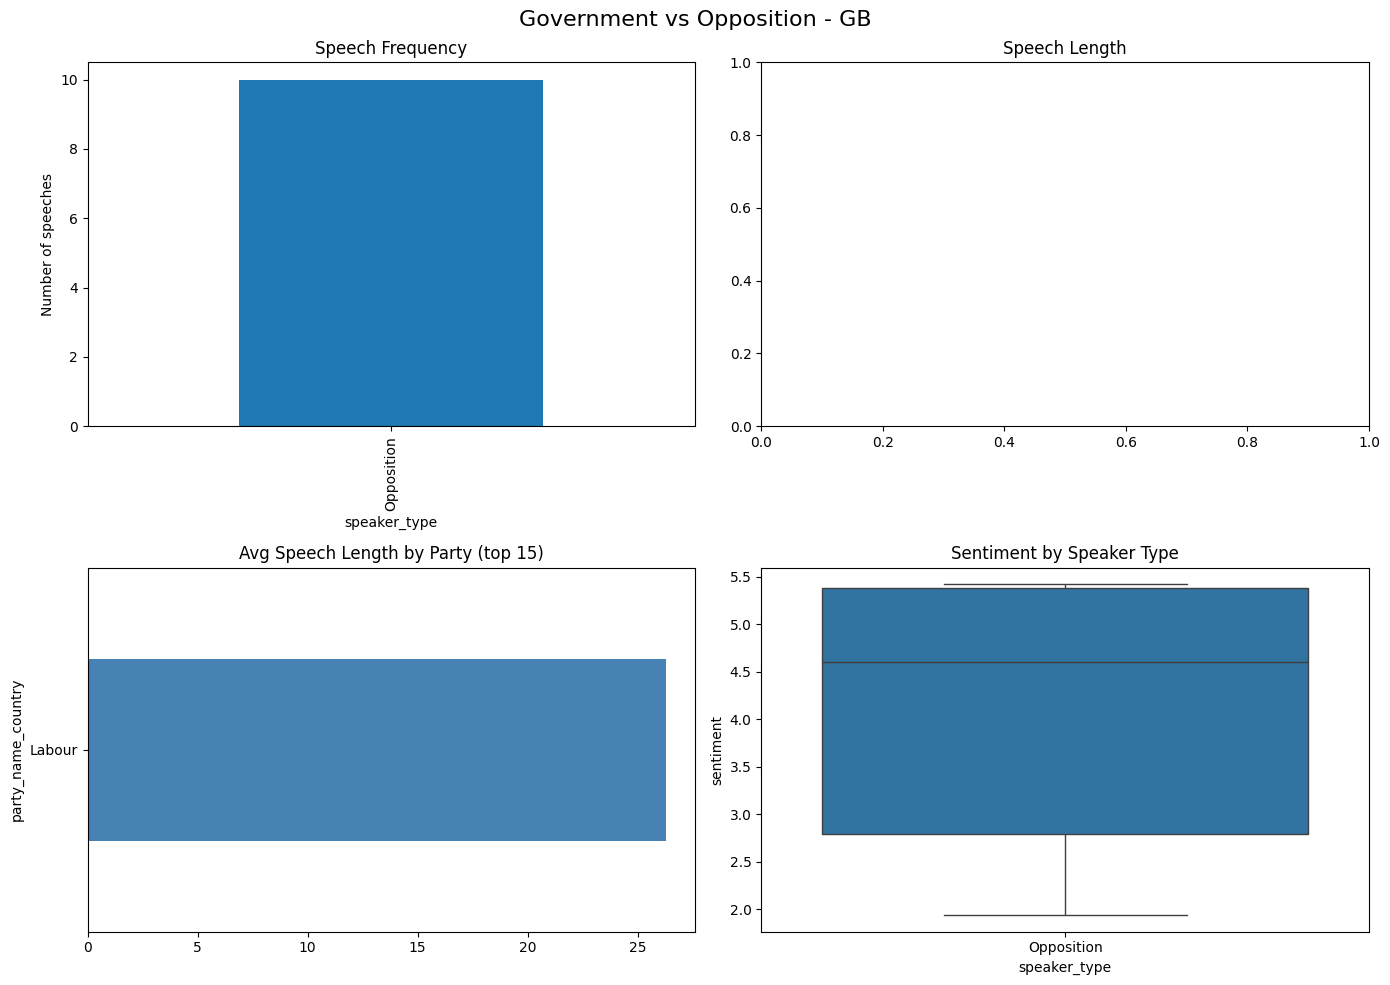


COUNTRY: GR

Government coalition parties (ids): ['party.ΣΥΡΙΖΑ', 'party.ΑΝΕΛ']
Opposition parties (ids): ['party.ΝΔ', 'party.ΠΑΣΟΚ', 'party.ΚΙΝΑΛ', 'party.KKE', 'party.Ε_Λ', 'party.ΣΥΡΙΖΑ', 'party.ΜέΡΑ25', 'party.Χ_Α', 'party.ΔΗΣΥ', 'party.Ε_Κ', 'party.ΤΟ_ΠΟΤΑΜΙ']

=== SPEECH FREQUENCY ===
speaker_type
Opposition    110
Government      3
Name: count, dtype: int64

Percentage:
speaker_type
Opposition    97.35
Government     2.65
Name: count, dtype: float64

=== SPEECH LENGTH ===
Government - mean/median/std: 49.0 29.0 47.29
Opposition - mean/median/std: 29.1 23.0 19.29

=== SENTIMENT ===
Government sentiment mean: 2.806 count: 3
Opposition sentiment mean: 2.44 count: 110


/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])


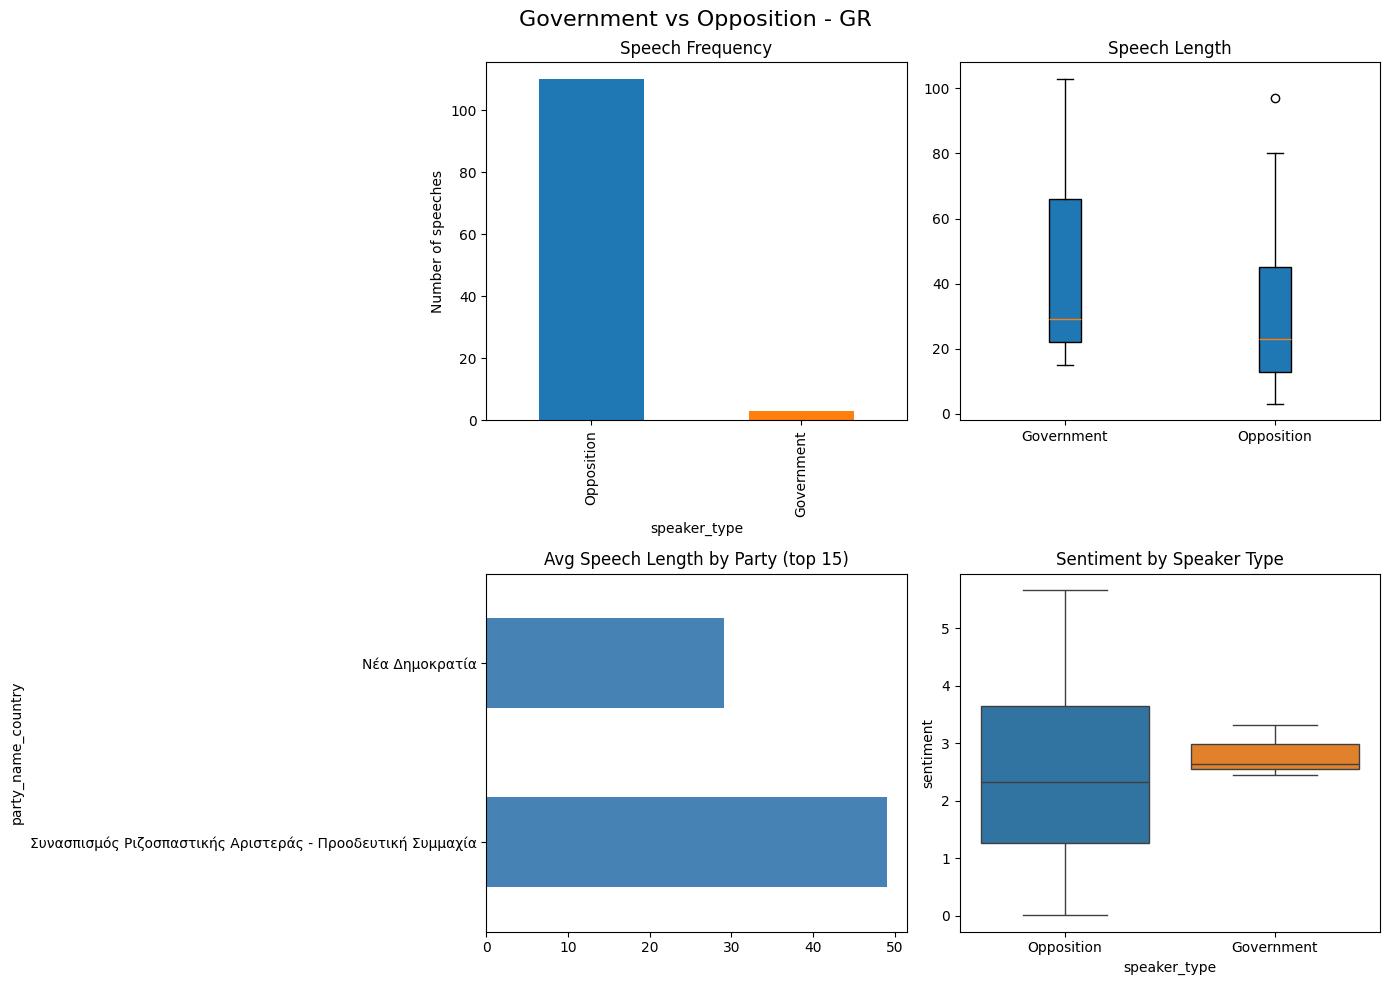


COUNTRY: HR

Government coalition parties (ids): ['party.ŽIVI_ZID', 'party.SNAGA', 'party.HRAST', 'party.HSU', 'party.BUZ', 'party.HNS', 'party.DC', 'party.GLAS', 'party.HDSSB', 'party.HSLS', 'party.FOKUS', 'party.ZK', 'party.HSS', 'party.HSP_AS', 'party.IDS', 'party.REFORMISTI', 'party.PGS', 'party.MDS', 'party.HRVATSKI_LABURISTI', 'party.HDS', 'party.DP', 'party.SDP', 'party.SBHS', 'party.PH', 'party.SIP', 'party.HSP', 'party.HGS', 'party.BM365', 'party.PAMETNO', 'party.HDZ']
Opposition parties (ids): ['party.ŽIVI_ZID', 'party.MOST', 'party.HSU', 'party.SDAH', 'party.ID', 'party.GLAS', 'party.HNS', 'party.HDSSB', 'party.HSS', 'party.IDS', 'party.REFORMISTI', 'party.HRID', 'party.SDSS', 'party.SMSH', 'party.HRVATSKI_LABURISTI', 'party.NOVI_VAL', 'party.NLSP', 'party.SDP', 'party.PH', 'party.HSD', 'party.BDSH', 'party.ORAH', 'party.HSP', 'party.NAPRIJED_HRVATSKA', 'party.HDZ']

=== SPEECH FREQUENCY ===
speaker_type
Government    47
Opposition     3
Name: count, dtype: int64

Percentag

/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])


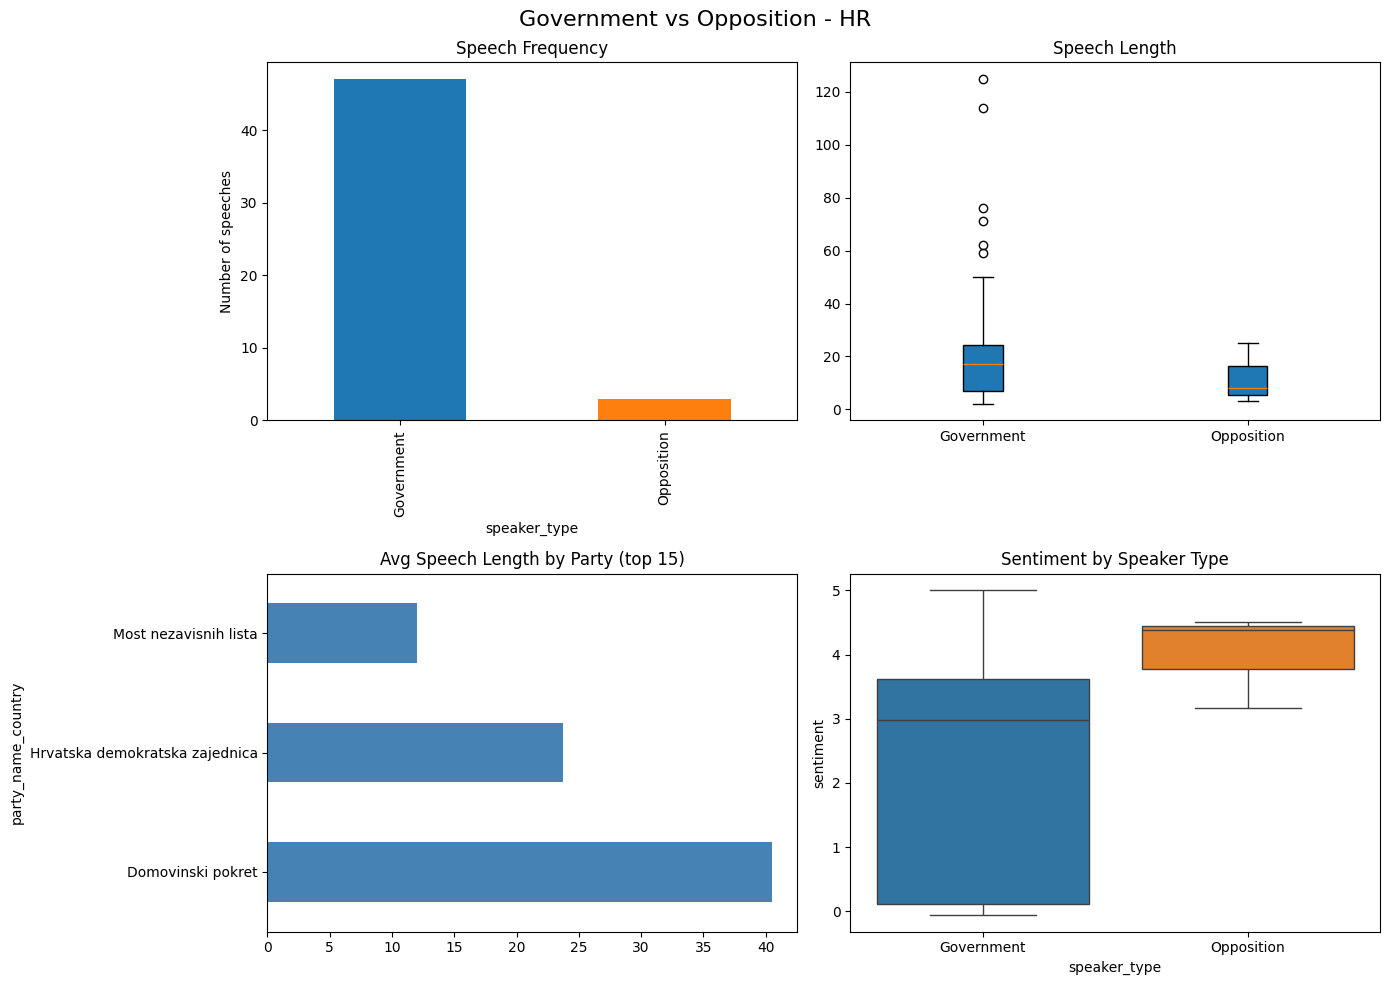


COUNTRY: HU

Government coalition parties (ids): ['parliamentaryGroup.KDNP.7', 'parliamentaryGroup.KDNP.8', 'parliamentaryGroup.KDNP.9', 'parliamentaryGroup.Fidesz.8', 'parliamentaryGroup.Fidesz.9', 'parliamentaryGroup.Fidesz.7']
Opposition parties (ids): ['parliamentaryGroup.LMP.9', 'parliamentaryGroup.Momentum.9', 'parliamentaryGroup.DK.9', 'parliamentaryGroup.Parbeszed.9', 'parliamentaryGroup.LMP.7', 'parliamentaryGroup.JOBBIK.9', 'parliamentaryGroup.MSZP.9', 'parliamentaryGroup.DK.8', 'parliamentaryGroup.MiHazank.9', 'parliamentaryGroup.MSZP.7', 'parliamentaryGroup.Parbeszed.8', 'parliamentaryGroup.MSZP.8', 'parliamentaryGroup.JOBBIK.8', 'parliamentaryGroup.JOBBIK.7', 'parliamentaryGroup.LMP.8']
Not enough classified speeches for HU (found 0), skipping

COUNTRY: IS

Government coalition parties (ids): ['party.Bf', 'party.F', 'party.V', 'party.S', 'party.Vg']
Opposition parties (ids): []
Not enough classified speeches for IS (found 0), skipping

COUNTRY: IT


/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)



Government coalition parties (ids): ['group.NCD', 'group.AP.NCD-UDC', 'group.PI', 'group.Aut.SVP-PATT.UV', 'group.M5S.2', 'group.L-SP-PSd.Az', 'group.PdL', 'group.L-SP', 'group.SCpI', 'group.PD', 'group.IV-PSI', 'group.Aut.SVP.UV.PATT.UPT.PSI-MAIE', 'group.Aut.SVP.UV.PATT.UPT.PSI', 'group.AP-CpE-NCD', 'group.FI-BP']
Opposition parties (ids): ['group.M5S.2', 'group.M5S.1', 'group.Aut.SVP-PATT.UV', 'group.L-SP-PSd.Az', 'group.L-SP', 'group.PD', 'group.FI-BP', 'group.FI-PdL.XVII', 'group.LN-Aut', 'group.FdI', 'group.Art.1-MDP', 'group.FIBP-UDC']
Not enough classified speeches for IT (found 0), skipping

COUNTRY: LV

Government coalition parties (ids): ['group.JK', 'group.JV', 'group.ZZS', 'group.VIENOTĪBA', 'group.KPV-LV', 'group.AP', 'group.NA']
Opposition parties (ids): ['group.LRA', 'group.SASKAŅA', 'group.ZZS']
Not enough classified speeches for LV (found 0), skipping

COUNTRY: NL

Government coalition parties (ids): ['party.CDA', 'party.D66', 'party.PvdA', 'party.ChristenUnie', 'par

/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])


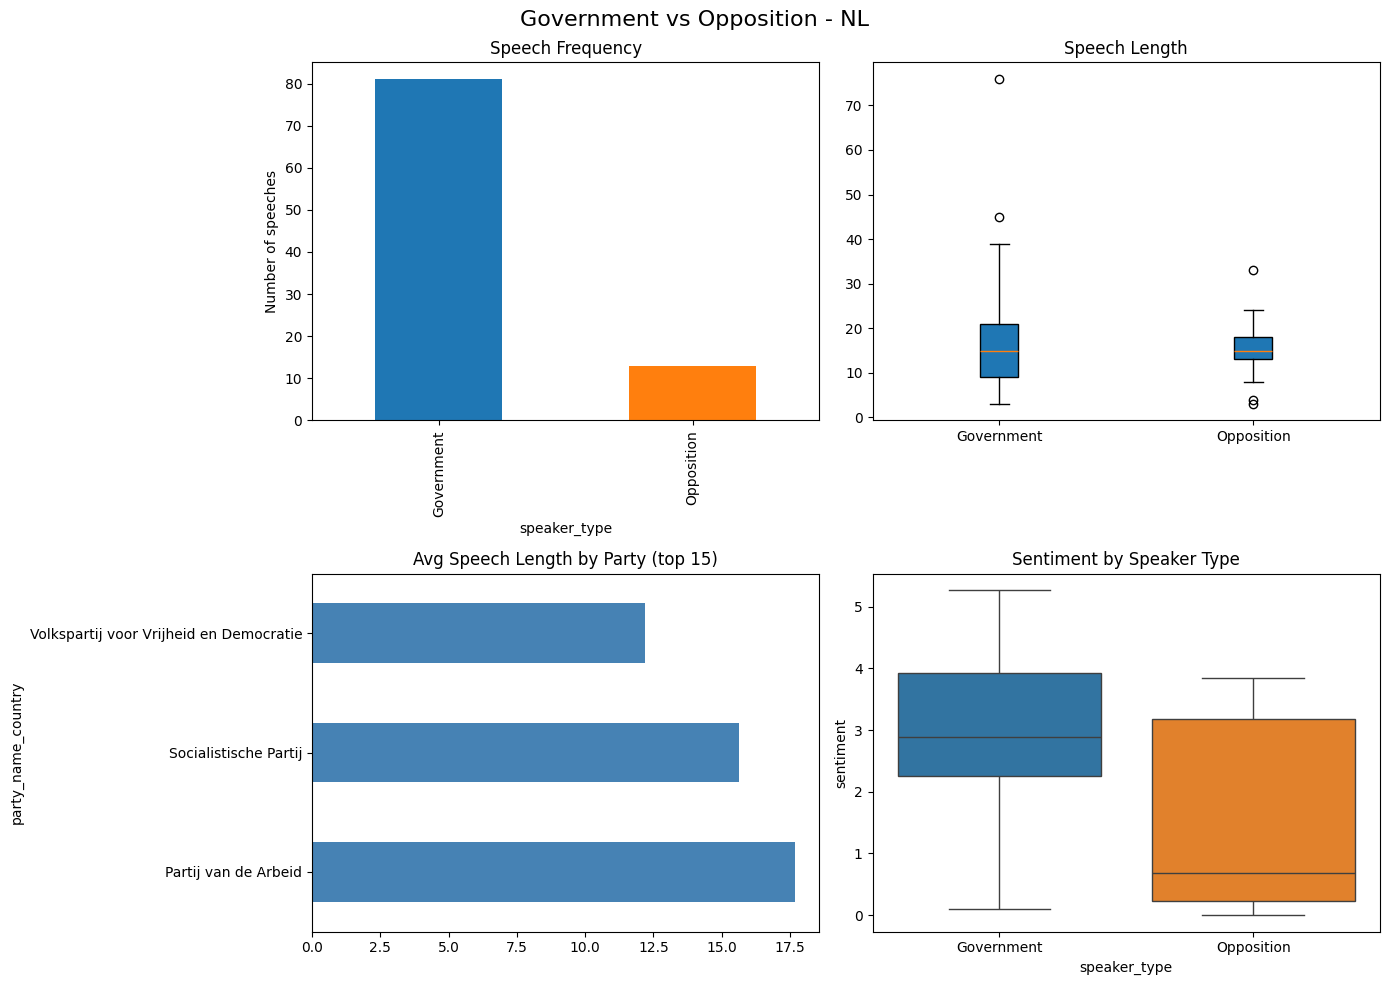


COUNTRY: NO

Government coalition parties (ids): ['party.FRP', 'party.H', 'party.SV', 'party.V', 'party.A', 'party.SP', 'party.KRF']
Opposition parties (ids): []

=== SPEECH FREQUENCY ===
speaker_type
Government    57
Name: count, dtype: int64

Percentage:
speaker_type
Government    100.0
Name: count, dtype: float64

=== SPEECH LENGTH ===

=== SENTIMENT ===
Government sentiment mean: 2.304 count: 57


/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])


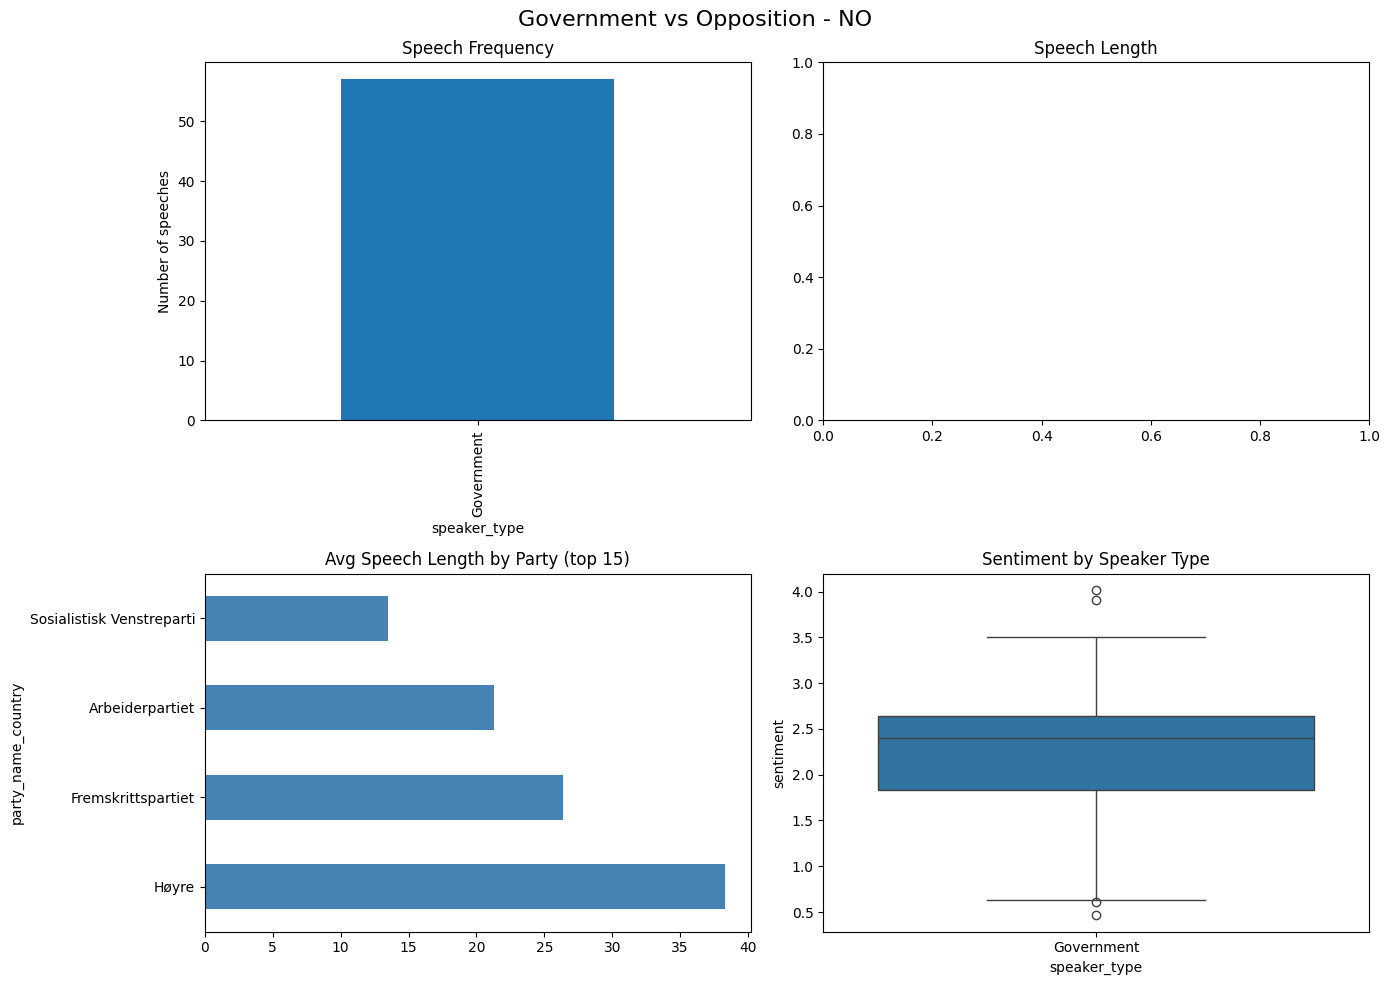


COUNTRY: PL

Government coalition parties (ids): ['party.PiS']
Opposition parties (ids): ['party.Kukiz15', 'party.Teraz', 'party.UPR', 'party.KP-PSL', 'party.PrzywrócićPrawo', 'party.Konfederacja', 'party.Lewica', 'party.KO']
Not enough classified speeches for PL (found 0), skipping

COUNTRY: PT

Government coalition parties (ids): ['PSD', 'PS', 'CDS-PP']
Opposition parties (ids): ['PSD', 'IL', 'CH', 'PAN', 'CDS-PP', 'PEV', 'PCP', 'BE', 'PS', 'L']

=== SPEECH FREQUENCY ===
speaker_type
Government    38
Opposition    33
Name: count, dtype: int64

Percentage:
speaker_type
Government    53.52
Opposition    46.48
Name: count, dtype: float64

=== SPEECH LENGTH ===
Government - mean/median/std: 84.55 40.0 178.11
Opposition - mean/median/std: 70.0 52.0 60.31

=== SENTIMENT ===
Government sentiment mean: 2.717 count: 38
Opposition sentiment mean: 1.989 count: 33


/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])


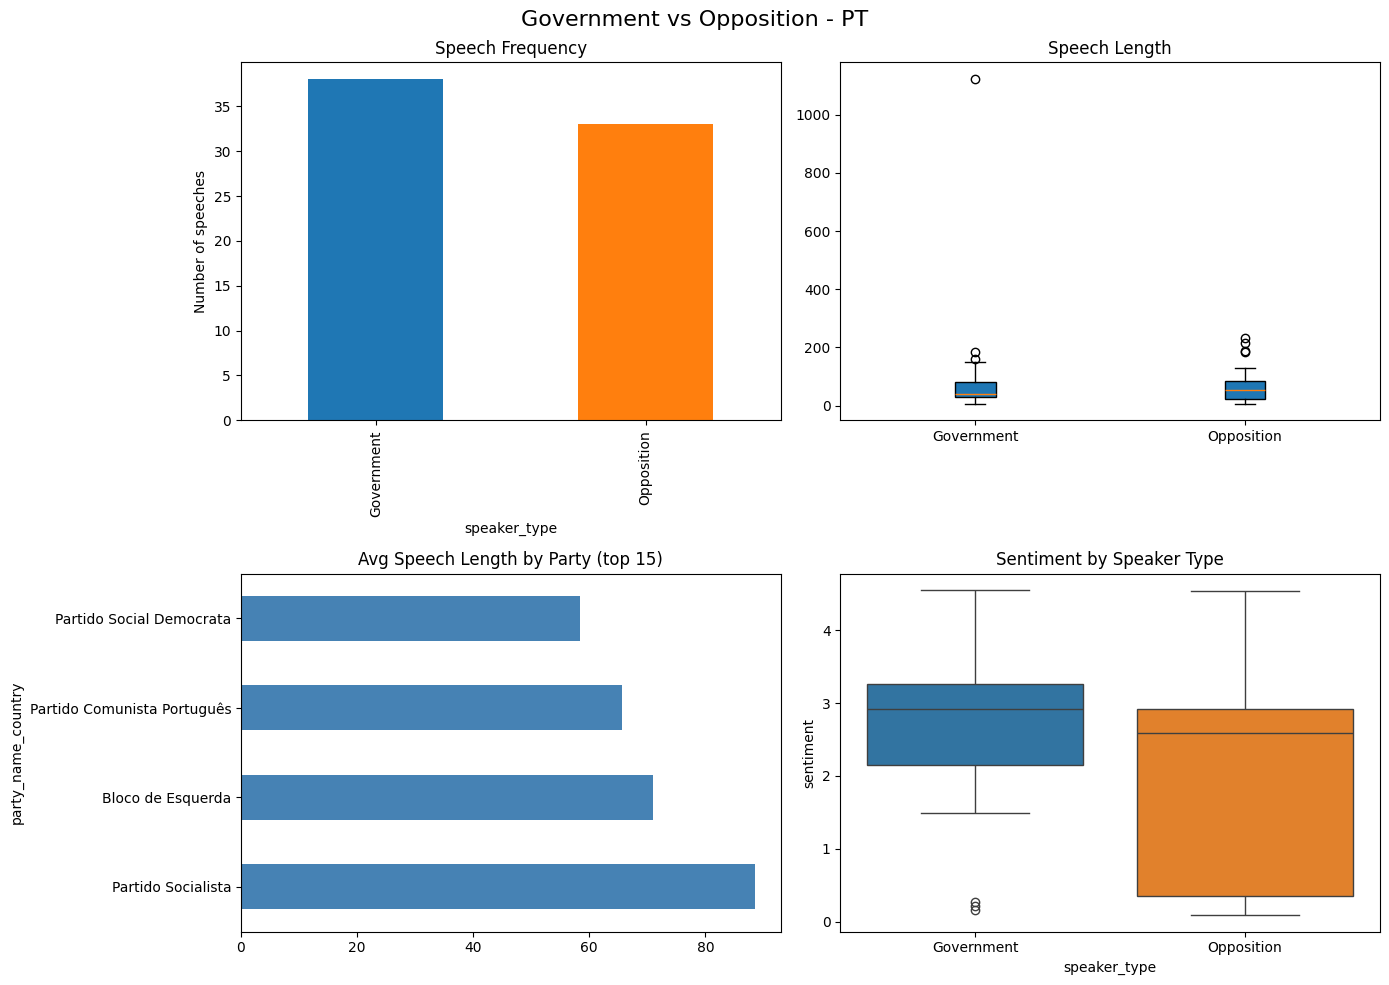


COUNTRY: RS


/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])



Government coalition parties (ids): ['party.BOGS', 'party.USS', 'party.DOS', 'party.PUPS', 'party.BDSS', 'party.SLPS', 'party.DPM', 'party.DVERI', 'party.SSJ', 'party.SDS', 'party.LŠ', 'party.BNS', 'party.SNS', 'party.DHSS', 'party.DS', 'party.DA', 'party.BDZ', 'party.SPS', 'party.SVM', 'party.ZS', 'party.ZZŠ', 'party.SPP', 'party.RP', 'party.LDP', 'party.ZZS', 'party.PSSBK', 'party.LSV', 'party.SDP', 'party.G17', 'party.SPO', 'party.NOVA', 'party.JS', 'party.PS', 'party.DSS', 'party.DSHV', 'party.SDU', 'party.KP', 'party.SDPS', 'party.SNP', 'party.SDA', 'party.NSS', 'party.NS', 'party.GSS']
Opposition parties (ids): ['party.SPO', 'party.SPP', 'party.DSS', 'party.G17', 'party.PDD', 'party.RP', 'party.DHSS', 'party.NОPO', 'party.DA', 'party.URS', 'party.BDSS', 'party.ZES', 'party.SPS', 'party.SVM', 'party.SDA', 'party.DKPB', 'party.SRS', 'party.DJB']
Not enough classified speeches for RS (found 0), skipping

COUNTRY: SE

Government coalition parties (ids): ['Q213451', 'Q110857', 'Q2136

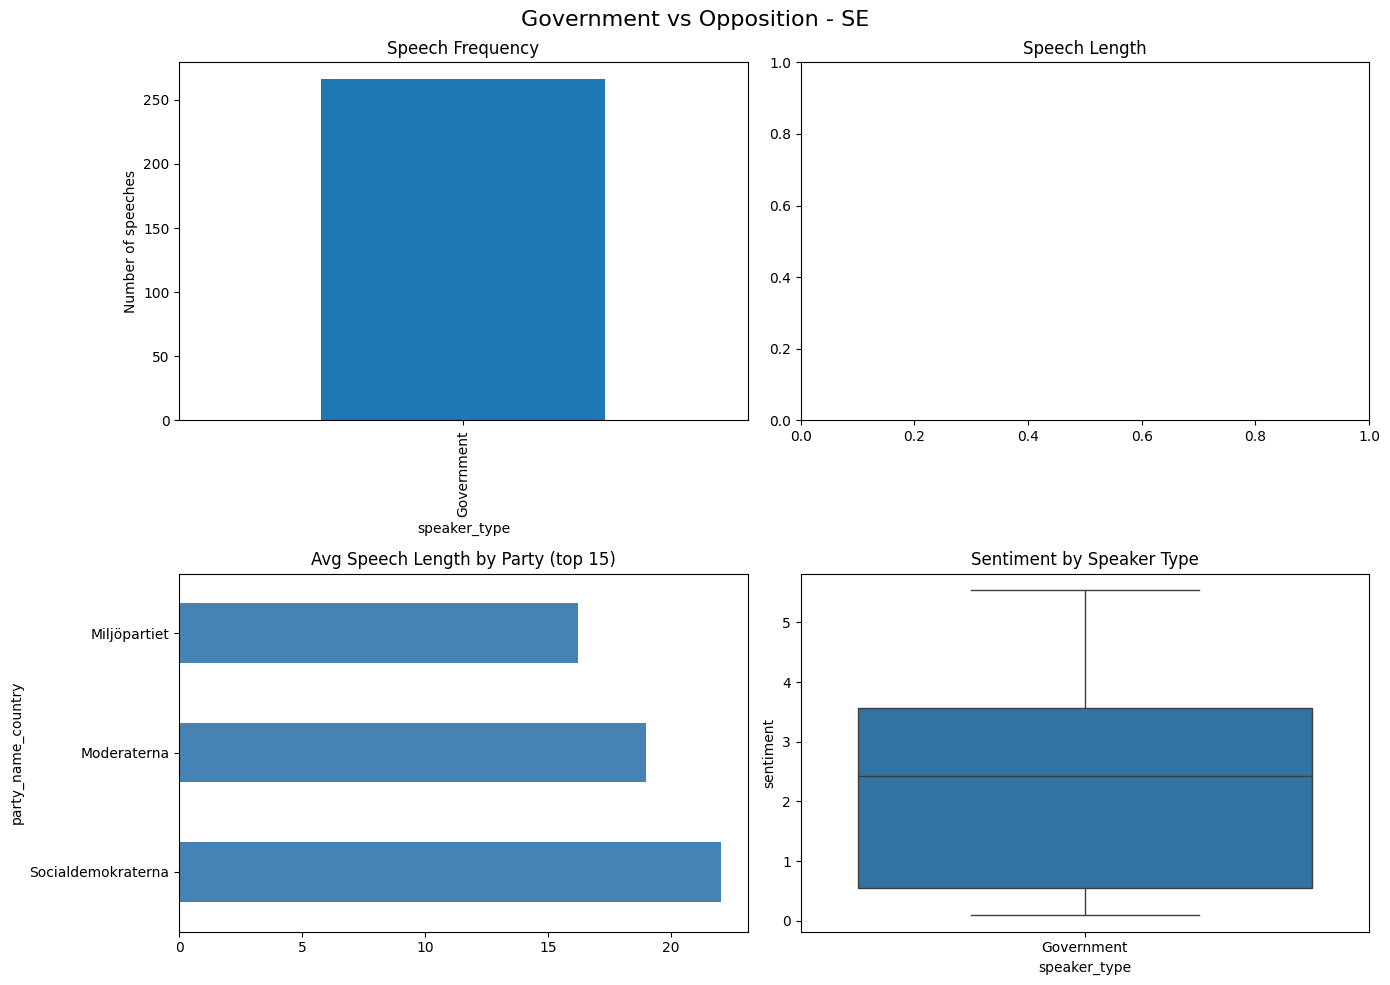


COUNTRY: SI

Government coalition parties (ids): ['party.DeSUS', 'party.DL', 'party.SMS', 'party.NSi', 'party.DLGV', 'party.PS', 'party.SMC.2', 'party.Zares.1', 'party.LDS.2', 'party.SDS.2', 'party.LMŠ', 'party.SD', 'party.SAB', 'party.SLS.2', 'party.Konkretno', 'party.SLS-SKD', 'party.SMC.1', 'party.ZLSD']
Opposition parties (ids): ['party.Levica.2', 'party.DeSUS', 'party.DL', 'party.PS', 'party.NSi', 'party.SNS', 'party.LDS.2', 'party.Levica.1', 'party.SDS.2', 'party.ZaAB', 'party.LMŠ', 'party.SD', 'party.SAB', 'party.SLS.2', 'party.Zares.1']
Not enough classified speeches for SI (found 0), skipping

COUNTRY: TR

Government coalition parties (ids): ['party.AKP']
Opposition parties (ids): ['party.Fazilet', 'party.ANAP', 'party.IYI', 'party.CHP', 'party.ANA', 'party.BBP', 'party.Saadet', 'party.HDP', 'party.eParti', 'party.MHP', 'party.DYP', 'party.MEP', 'party.BDP', 'party.TIP', 'party.YP', 'party.DP', 'party.DSP', 'party.DEVA']

=== SPEECH FREQUENCY ===
speaker_type
Government    34

/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)
/var/folders/lp/4vbz2pkn62n5gbqhn5nxcggm0000gn/T/ipykernel_16806/4278959910.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])


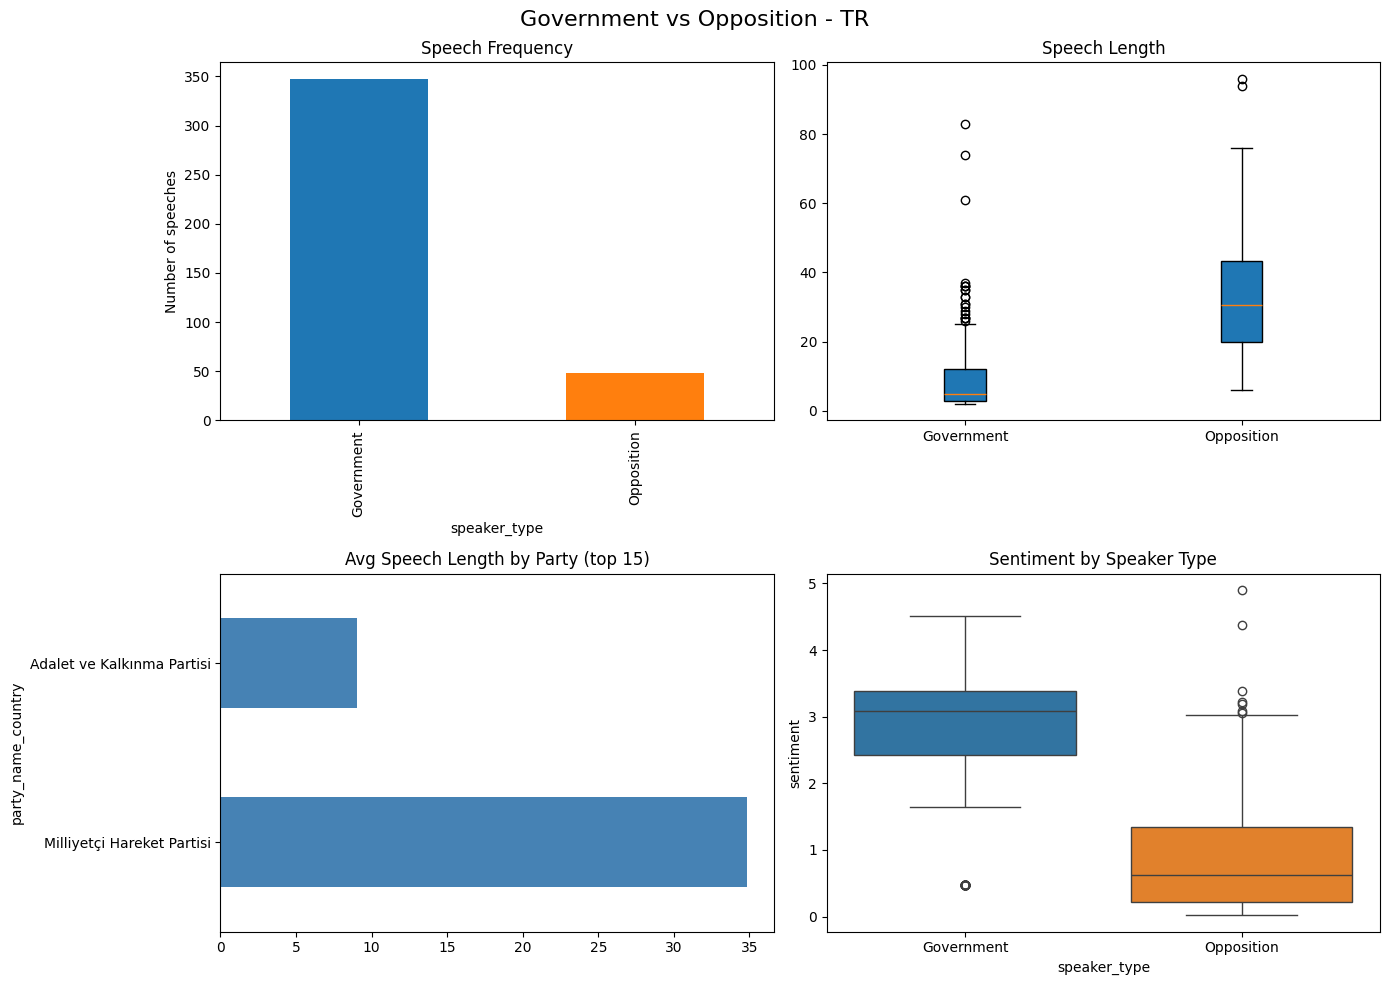


COUNTRY: UA

Government coalition parties (ids): ['fr.nuns', 'fr.es', 'fr.hol', 'fr.nf', 'fr.nru', 'fr.ppu', 'fr.sv', 'fr.np1', 'fr.sn', 'gr.narod', 'fr.NDP-Lab', 'fr.ud', 'fr.reg', 'fr.NSNU', 'gr.pch', 'fr.but', 'fr.unp', 'gr.pw', 'fr.ppu-Lab', 'gr.eu', 'gr.pzm', 'fr.nu02', 'fr.FU', 'fr.bl', 'fr.napu', 'fr.NDP', 'gr.pwill', 'gr.vu', 'fr.PRP', 'fr.spu', 'fr.rp', 'gr.ech', 'fr.edup', 'gr.demi', 'gr.Soyuz', 'fr.regU', 'fr.sdpuo', 'fr.nu06', 'fr.bpp', 'fr.byut', 'gr.ed', 'gr.dU', 'gr.dvr', 'gr.pvd', 'gr.pzhim', 'fr.sp', 'fr.kpu', 'fr.Lab-NDP', 'fr.au', 'gr.centre']
Opposition parties (ids): ['fr.nuns', 'fr.es', 'fr.hol', 'fr.sv', 'fr.ud', 'fr.reg', 'fr.but', 'fr.ob', 'fr.bl', 'fr.nu02', 'fr.opzzh', 'fr.spu', 'fr.sdpuo', 'fr.nu06', 'fr.byut', 'gr.ed', 'fr.sp', 'fr.kpu', 'fr.rp']
Not enough classified speeches for UA (found 0), skipping


In [26]:
# Government vs Opposition Analysis - Per country (uses final_df['country_code'])
import matplotlib.pyplot as plt
import seaborn as sns

# Robust extractor for coalition/opposition relations
def get_govt_opposition_from_listorg(org_path):
    tree = etree.parse(str(org_path))
    root = tree.getroot()
    govt_parties = set()
    opp_parties = set()

    # Coalition relations (government)
    for coal in root.xpath("//tei:relation[@name='coalition']", namespaces=NS):
        vals = (coal.get('mutual') or '')
        ids = [v.replace('#', '').strip() for v in vals.split() if v.strip()]
        govt_parties.update(ids)

    # Opposition relations
    for rel in root.xpath("//tei:relation[@name='opposition']", namespaces=NS):
        vals = (rel.get('active') or '')
        ids = [v.replace('#', '').strip() for v in vals.split() if v.strip()]
        opp_parties.update(ids)

    return list(govt_parties), list(opp_parties)

# Ensure speech length exists
if 'speech_length' not in final_df.columns:
    final_df['speech_length'] = final_df['tokens'].map(len)

# Iterate countries present in final_df
countries = sorted([c for c in final_df['country_code'].dropna().unique() if c not in (['Unknown'] + selected_countries)])

for country_code in countries:
    country_dir = data_path / 'Samples' / f'ParlaMint-{country_code}'
    person_path = country_dir / f'ParlaMint-{country_code}-listPerson.xml'
    org_path = country_dir / f'ParlaMint-{country_code}-listOrg.xml'

    print('\n' + '='*70)
    print(f'COUNTRY: {country_code}')
    print('='*70)

    if not person_path.exists() or not org_path.exists():
        print(f'Missing metadata files for {country_code}, skipping')
        continue

    country_speaker_info = load_person_list(person_path)
    country_org_info = load_org_list(org_path)
    govt_parties, opp_parties = get_govt_opposition_from_listorg(org_path)

    print('\nGovernment coalition parties (ids):', govt_parties)
    print('Opposition parties (ids):', opp_parties)

    # Filter data for this country
    country_data = final_df[final_df['country_code'] == country_code].copy()
    if country_data.empty:
        print(f'No data for {country_code}, skipping')
        continue

    # Map party names using country-specific org info
    country_data['party_name_country'] = country_data['party_id'].map(lambda x: country_org_info.get(x, {}).get('name', 'Unknown'))

    # Classify speaker type using party_id matching the relation ids
    country_data['speaker_type'] = country_data['party_id'].apply(
        lambda x: 'Government' if x in govt_parties else ('Opposition' if x in opp_parties else 'Other')
    )

    # Keep only Gov/Opp for the main comparisons
    country_data_class = country_data[country_data['speaker_type'].isin(['Government', 'Opposition'])].copy()
    if len(country_data_class) < 10:
        print(f'Not enough classified speeches for {country_code} (found {len(country_data_class)}), skipping')
        continue

    # Frequency
    print('\n=== SPEECH FREQUENCY ===')
    freq_by_type = country_data_class['speaker_type'].value_counts()
    print(freq_by_type)
    print('\nPercentage:')
    print((freq_by_type / len(country_data_class) * 100).round(2))

    # Lengths
    print('\n=== SPEECH LENGTH ===')
    govt_lengths = country_data_class[country_data_class['speaker_type'] == 'Government']['speech_length']
    opp_lengths = country_data_class[country_data_class['speaker_type'] == 'Opposition']['speech_length']
    if len(govt_lengths) and len(opp_lengths):
        print('Government - mean/median/std:', round(govt_lengths.mean(),2), round(govt_lengths.median(),2), round(govt_lengths.std(),2))
        print('Opposition - mean/median/std:', round(opp_lengths.mean(),2), round(opp_lengths.median(),2), round(opp_lengths.std(),2))

    # Sentiment
    print('\n=== SENTIMENT ===')
    govt_sent = country_data_class[country_data_class['speaker_type']=='Government']['sentiment'].dropna()
    opp_sent = country_data_class[country_data_class['speaker_type']=='Opposition']['sentiment'].dropna()
    if len(govt_sent):
        print('Government sentiment mean:', round(govt_sent.mean(),3), 'count:', len(govt_sent))
    if len(opp_sent):
        print('Opposition sentiment mean:', round(opp_sent.mean(),3), 'count:', len(opp_sent))

    # Plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Government vs Opposition - {country_code}', fontsize=16)

    # Frequency bar
    ax = axes[0,0]
    freq_by_type.plot(kind='bar', ax=ax, color=['#1f77b4','#ff7f0e'])
    ax.set_title('Speech Frequency')
    ax.set_ylabel('Number of speeches')

    # Length box
    ax = axes[0,1]
    if len(govt_lengths) and len(opp_lengths):
        ax.boxplot([govt_lengths, opp_lengths], labels=['Government','Opposition'], patch_artist=True)
    ax.set_title('Speech Length')

    # Avg length by party
    ax = axes[1,0]
    party_avg = country_data_class.groupby('party_name_country')['speech_length'].mean().sort_values(ascending=False)
    if len(party_avg):
        party_avg.head(15).plot(kind='barh', ax=ax, color='steelblue')
        ax.set_title('Avg Speech Length by Party (top 15)')

    # Sentiment box
    ax = axes[1,1]
    sent_data = country_data_class.dropna(subset=['sentiment'])
    if len(sent_data):
        sns.boxplot(x='speaker_type', y='sentiment', data=sent_data, ax=ax, palette=['#1f77b4','#ff7f0e'])
        ax.set_title('Sentiment by Speaker Type')

    plt.tight_layout()
    plt.show()

In [31]:
# print from final df everything from country_code 'BA'. Print the name of the speaker and the party name
ba_speeches = final_df[final_df['country_code'] == 'BA'][['s_id', 'speaker_name', 'party_name', 'speaker_sex', 'text']]
print(f"Speeches from country code 'BA':")
print(ba_speeches.head(50))

info = load_person_list(data_path / "Samples" / "ParlaMint-BA" / "ParlaMint-BA-listPerson.xml")
print(info.get("#BećirovićDenis"))

Speeches from country code 'BA':
                                          s_id      speaker_name party_name  \
3402   ParlaMint-BA_2013-10-07-0.u17114.seg0.1   Denis Bećirović    Unknown   
3403   ParlaMint-BA_2013-10-07-0.u17114.seg0.2   Denis Bećirović    Unknown   
3404   ParlaMint-BA_2013-10-07-0.u17114.seg0.3   Denis Bećirović    Unknown   
3405   ParlaMint-BA_2013-10-07-0.u17114.seg0.4   Denis Bećirović    Unknown   
3406   ParlaMint-BA_2013-10-07-0.u17114.seg0.5   Denis Bećirović    Unknown   
3407   ParlaMint-BA_2013-10-07-0.u17114.seg0.6   Denis Bećirović    Unknown   
3408   ParlaMint-BA_2013-10-07-0.u17114.seg0.7   Denis Bećirović    Unknown   
3409   ParlaMint-BA_2013-10-07-0.u17114.seg0.8   Denis Bećirović    Unknown   
3410   ParlaMint-BA_2013-10-07-0.u17114.seg0.9   Denis Bećirović    Unknown   
3411  ParlaMint-BA_2013-10-07-0.u17114.seg0.10   Denis Bećirović    Unknown   
3412  ParlaMint-BA_2013-10-07-0.u17114.seg0.11   Denis Bećirović    Unknown   
3413  ParlaMint-BA_